<a href="https://colab.research.google.com/github/syedabusafwan/ML-practice/blob/main/CatvsDogv2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install -q kaggle
!kaggle datasets download salader/dogs-vs-cats -p /content

Dataset URL: https://www.kaggle.com/datasets/salader/dogs-vs-cats
License(s): unknown
100% 1.06G/1.06G [00:51<00:00, 23.1MB/s]
100% 1.06G/1.06G [00:51<00:00, 22.0MB/s]


In [2]:
# prompt: unzip

!unzip -q /content/dogs-vs-cats.zip -d /content


In [3]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import random
import pandas as pd
from PIL import Image
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from keras.utils import plot_model
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc

In [4]:
import os
import cv2
# Directory containing the "Train" folder
directory = "/content/dogs_vs_cats/train"

filepath = []
label = []
corrupted_images = []

folds = os.listdir(directory)

for fold in folds:
    f_path = os.path.join(directory, fold)

    imgs = os.listdir(f_path)

    for img in imgs:

        img_path = os.path.join(f_path, img)
        try:
            # Attempt to read the image
            img_array = cv2.imread(img_path)

            # Check if the image array is not empty
            if img_array is not None and not img_array.size == 0:
                filepath.append(img_path)
                label.append(fold)
            else:
                corrupted_images.append(img_path)

        except Exception as e:
            # If an error occurs, treat it as a corrupted image
            corrupted_images.append(img_path)
            continue

# Concat data paths with labels
file_path_series = pd.Series(filepath, name='filepath')
Label_path_series = pd.Series(label, name='label')
df_train = pd.concat([file_path_series, Label_path_series], axis=1)

# Remove corrupted images from the data frame
for corrupted_img_path in corrupted_images:
    df_train = df_train[df_train['filepath'] != corrupted_img_path]

print("Number of corrupted images removed:", len(corrupted_images))
print("Remaining images in the dataset:", len(df_train))

Number of corrupted images removed: 0
Remaining images in the dataset: 20000


In [5]:
df_train.head()

filepath label
0  /content/dogs_vs_cats/train/cats/cat.11182.jpg  cats
1   /content/dogs_vs_cats/train/cats/cat.8619.jpg  cats
2   /content/dogs_vs_cats/train/cats/cat.6904.jpg  cats
3   /content/dogs_vs_cats/train/cats/cat.3645.jpg  cats
4  /content/dogs_vs_cats/train/cats/cat.12338.jpg  cats

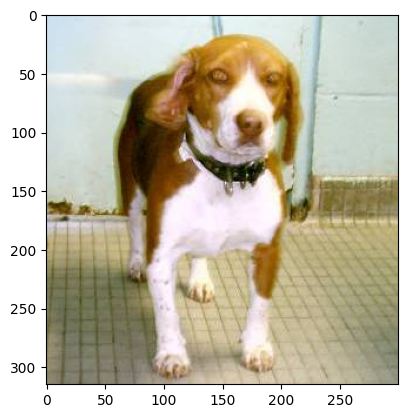

In [6]:
img = Image.open('/content/dogs_vs_cats/train/dogs/dog.2702.jpg')
plt.imshow(img)

In [7]:
num_images = 12
class_animal = 'Cat'
directory_path = '/content/dogs_vs_cats/train/cats'
image_filenames = os.listdir(directory_path)

if len(image_filenames) < num_images:
    print(f"Only found images {len(image_filenames)} images in {directory_path}, displaying them all.")
    num_images = len(image_filenames)

selected_images = random.sample(image_filenames, num_images)

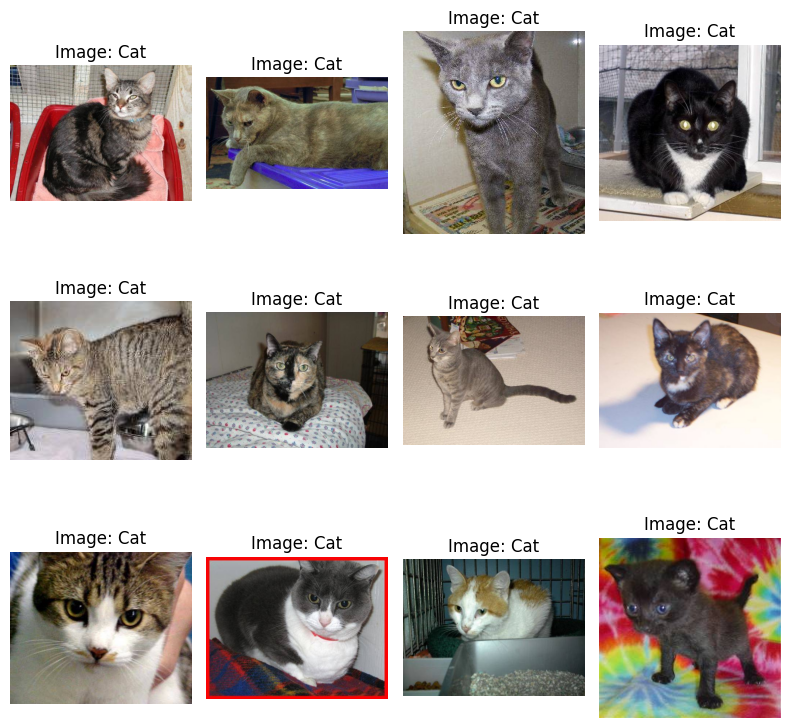

In [8]:
fig, axes = plt.subplots(3,4, figsize=(8, 8))
axes = axes.ravel()

for i, image_file in enumerate(selected_images):
    image_path = os.path.join(directory_path, image_file)
    image = Image.open(image_path)
    axes[i].imshow(image)
    axes[i].set_title(f"Image: {class_animal}")
    axes[i].axis('off')

plt.tight_layout()
plt.show()

In [9]:
num_images = 12
class_animal = 'Dog'
directory_path = '/content/dogs_vs_cats/train/dogs'
image_filenames = os.listdir(directory_path)

In [10]:
if len(image_filenames) < num_images:
    print(f"Only found images {len(image_filenames)} images in {directory_path}, displaying them all.")
    num_images = len(image_filenames)

In [11]:
selected_images = random.sample(image_filenames, num_images)

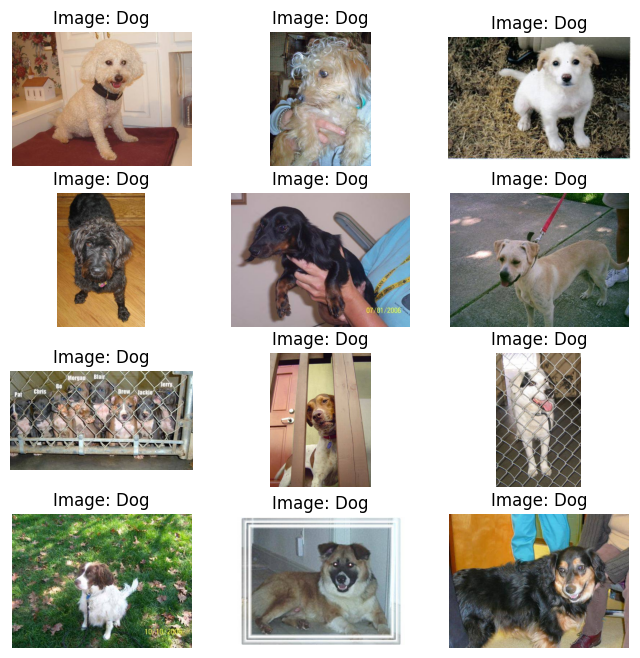

In [12]:
fig, axes = plt.subplots(4, 3, figsize=(8, 8))
axes = axes.ravel()

for i, image_file in enumerate(selected_images):
    image_path = os.path.join(directory_path, image_file)
    image = Image.open(image_path)
    axes[i].imshow(image)
    axes[i].set_title(f"Image: {class_animal}")
    axes[i].axis('off')

In [13]:
cat_directory_path = '/content/dogs_vs_cats/train/cats'
dog_directory_path = '/content/dogs_vs_cats/train/dogs'

cat_images = os.listdir(cat_directory_path)
dog_images = os.listdir(dog_directory_path)

classes_animals = ['Cats', 'Dogs']
count = [len(cat_images), len(dog_images)]

print(count)

[10000, 10000]


<ipython-input-14-f8231ac95a46>:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=count.index, y=count.values, ax=axs[1], palette="viridis")


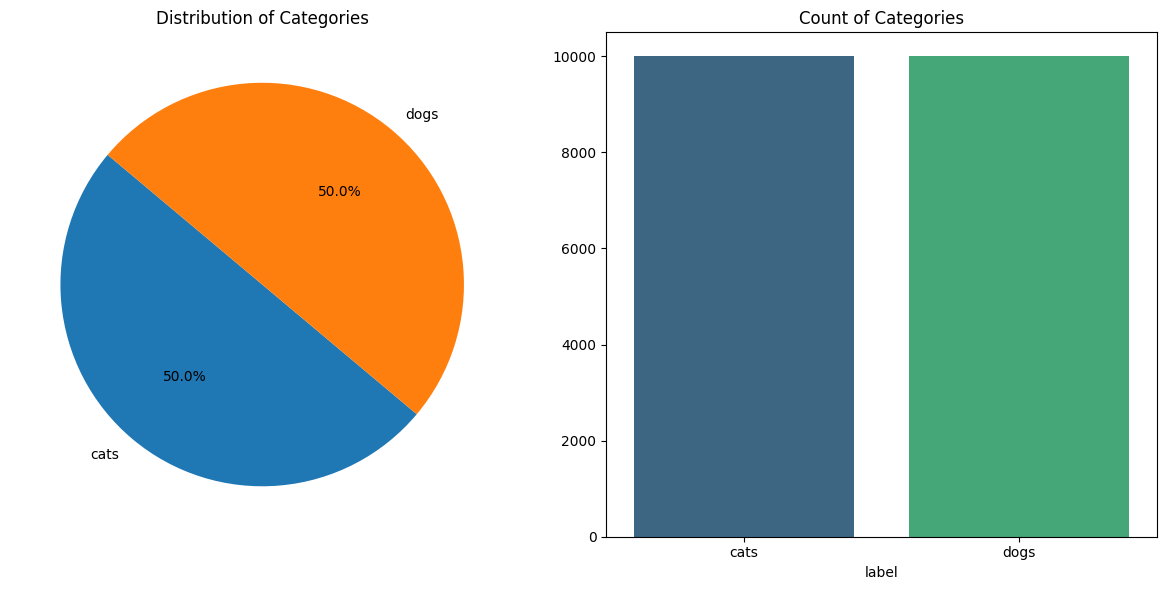

In [14]:
# Count the occurrences of each category in the 'category' column
count = df_train['label'].value_counts()

# Create a figure with two subplots
fig, axs = plt.subplots(1, 2, figsize=(12, 6), facecolor='white')

# Plot pie chart on the first subplot
palette = sns.color_palette("viridis")
sns.set_palette(palette)
axs[0].pie(count, labels=count.index, autopct='%1.1f%%', startangle=140)
axs[0].set_title('Distribution of Categories')

# Plot bar chart on the second subplot
sns.barplot(x=count.index, y=count.values, ax=axs[1], palette="viridis")
axs[1].set_title('Count of Categories')

# Adjust layout
plt.tight_layout()

# Show the plot
plt.show()

In [15]:
from sklearn.model_selection import train_test_split

# Split data into train, validation, and test sets
train_df, test_val_df = train_test_split(df_train, test_size=0.3, random_state=42)
test_df, val_df = train_test_split(test_val_df, test_size=0.5, random_state=42)

# Data generator for training
train_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_dataframe(
    dataframe=train_df,
    x_col="filepath",
    y_col="label",
    target_size=(150, 150),
    batch_size=20,
    class_mode="binary"
)

# Data generator for validation
validation_generator = train_datagen.flow_from_dataframe(
    dataframe=val_df,
    x_col="filepath",
    y_col="label",
    target_size=(150, 150),
    batch_size=20,
    class_mode="binary"
)

# Data generator for test
test_generator = train_datagen.flow_from_dataframe(
    dataframe=test_df,
    x_col="filepath",
    y_col="label",
    target_size=(150, 150),
    batch_size=20,
    class_mode="binary"
)

Found 14000 validated image filenames belonging to 2 classes.
Found 3000 validated image filenames belonging to 2 classes.
Found 3000 validated image filenames belonging to 2 classes.


In [16]:
train_class_labels = train_generator.class_indices
print("training class labels: ", train_class_labels)

validation_class_labels = validation_generator.class_indices
print('validation class labels: ', validation_class_labels)

training class labels:  {'cats': 0, 'dogs': 1}
validation class labels:  {'cats': 0, 'dogs': 1}


In [17]:
def plot_images_from_generator(generator, num_images=4):
    images, labels = next(generator)
    fig, axes = plt.subplots(1, num_images, figsize=(20, 20))
    axes = axes.flatten()

    for img, label, ax in zip(images, labels, axes):
        ax.imshow(img)
        class_labels = dict((v,k) for k,v in generator.class_indices.items())
        ax.set_title(class_labels[int(label)])
        ax.axis(False)

    plt.tight_layout()
    plt.show()

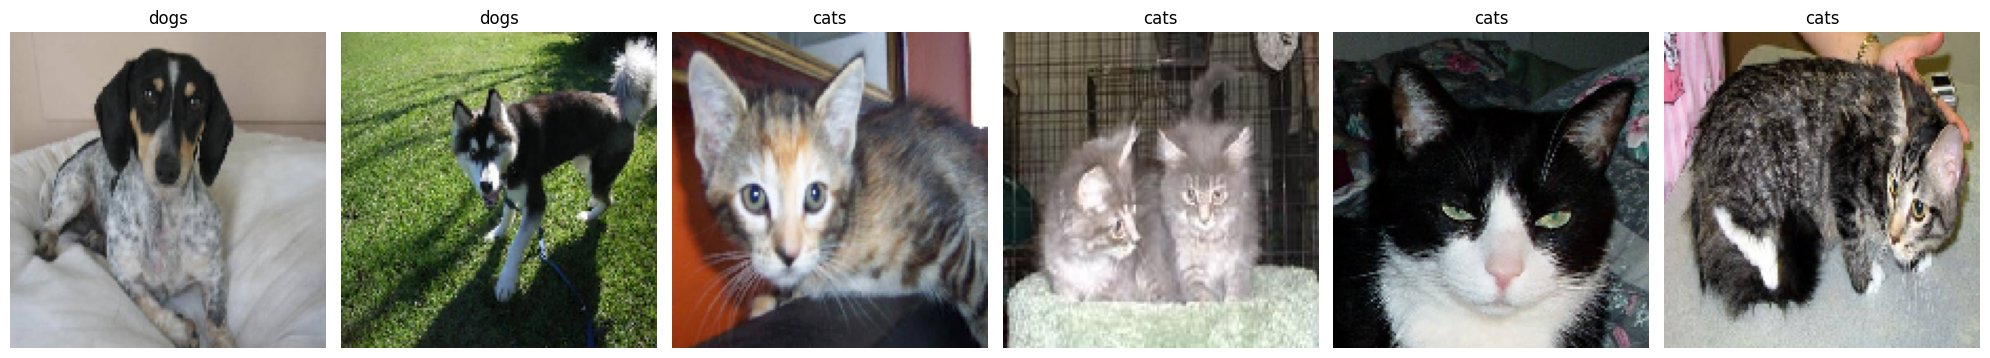

In [18]:
plot_images_from_generator(train_generator, num_images=6)

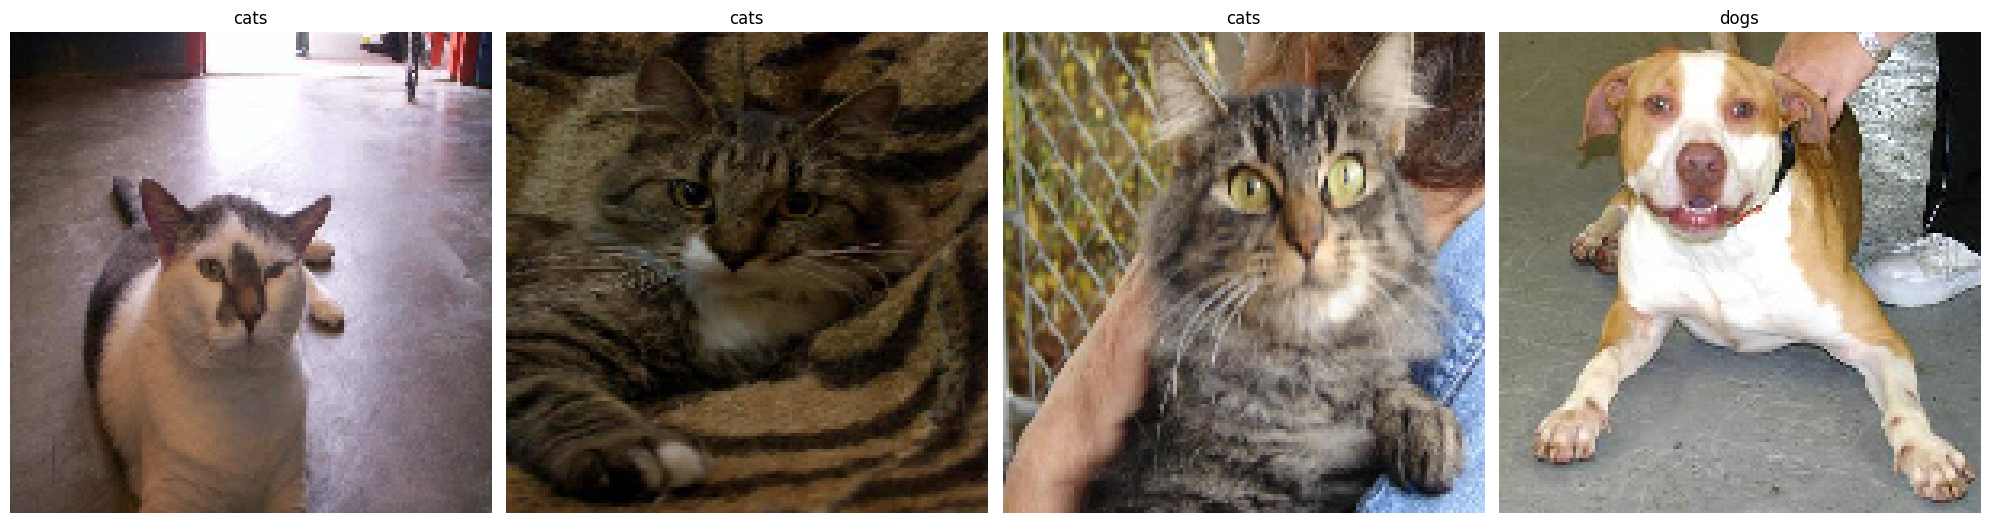

In [19]:
import matplotlib.pyplot as plt

# Function to plot images and their labels
def plot_images_from_generator(generator, num_images=4):
    # Get a batch of images and labels from the generator
    images, labels = next(generator)

    # Set up the plot
    fig, axes = plt.subplots(1, num_images, figsize=(20,20))
    axes = axes.flatten()

    for img, label, ax in zip(images, labels, axes):
        # Image preprocessing might differ, adjust accordingly
        ax.imshow(img)
        # Set the title to the class label
        # Inverse the class indices dictionary to get class names from labels
        class_labels = dict((v,k) for k,v in generator.class_indices.items())
        ax.set_title(class_labels[int(label)])
        ax.axis('off')
    plt.tight_layout()
    plt.show()

# Now, call this function with your training generator
plot_images_from_generator(train_generator, num_images=4)

In [20]:
train_generator.reset()
train_generator.reset()

In [21]:
model = models.Sequential([
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(150, 150, 3)),
    layers.MaxPooling2D(2, 2),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D(2, 2),
    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.MaxPooling2D(2, 2),
    layers.Conv2D(256, (3, 3), activation='relu'),
    layers.MaxPooling2D(2, 2),
    layers.Flatten(),
    layers.Dense(512, activation='relu'),
    layers.Dense(1, activation='sigmoid')
])

model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 148, 148, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 74, 74, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 72, 72, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 36, 36, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 34, 34, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 17, 17, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 15, 15, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 7, 7, 256)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 12544)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 512)                 │       6,423,040 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │             513 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 6,811,969 (25.99 MB)

 Trainable params: 6,811,969 (25.99 MB)

 Non-trainable params: 0 (0.00 B)

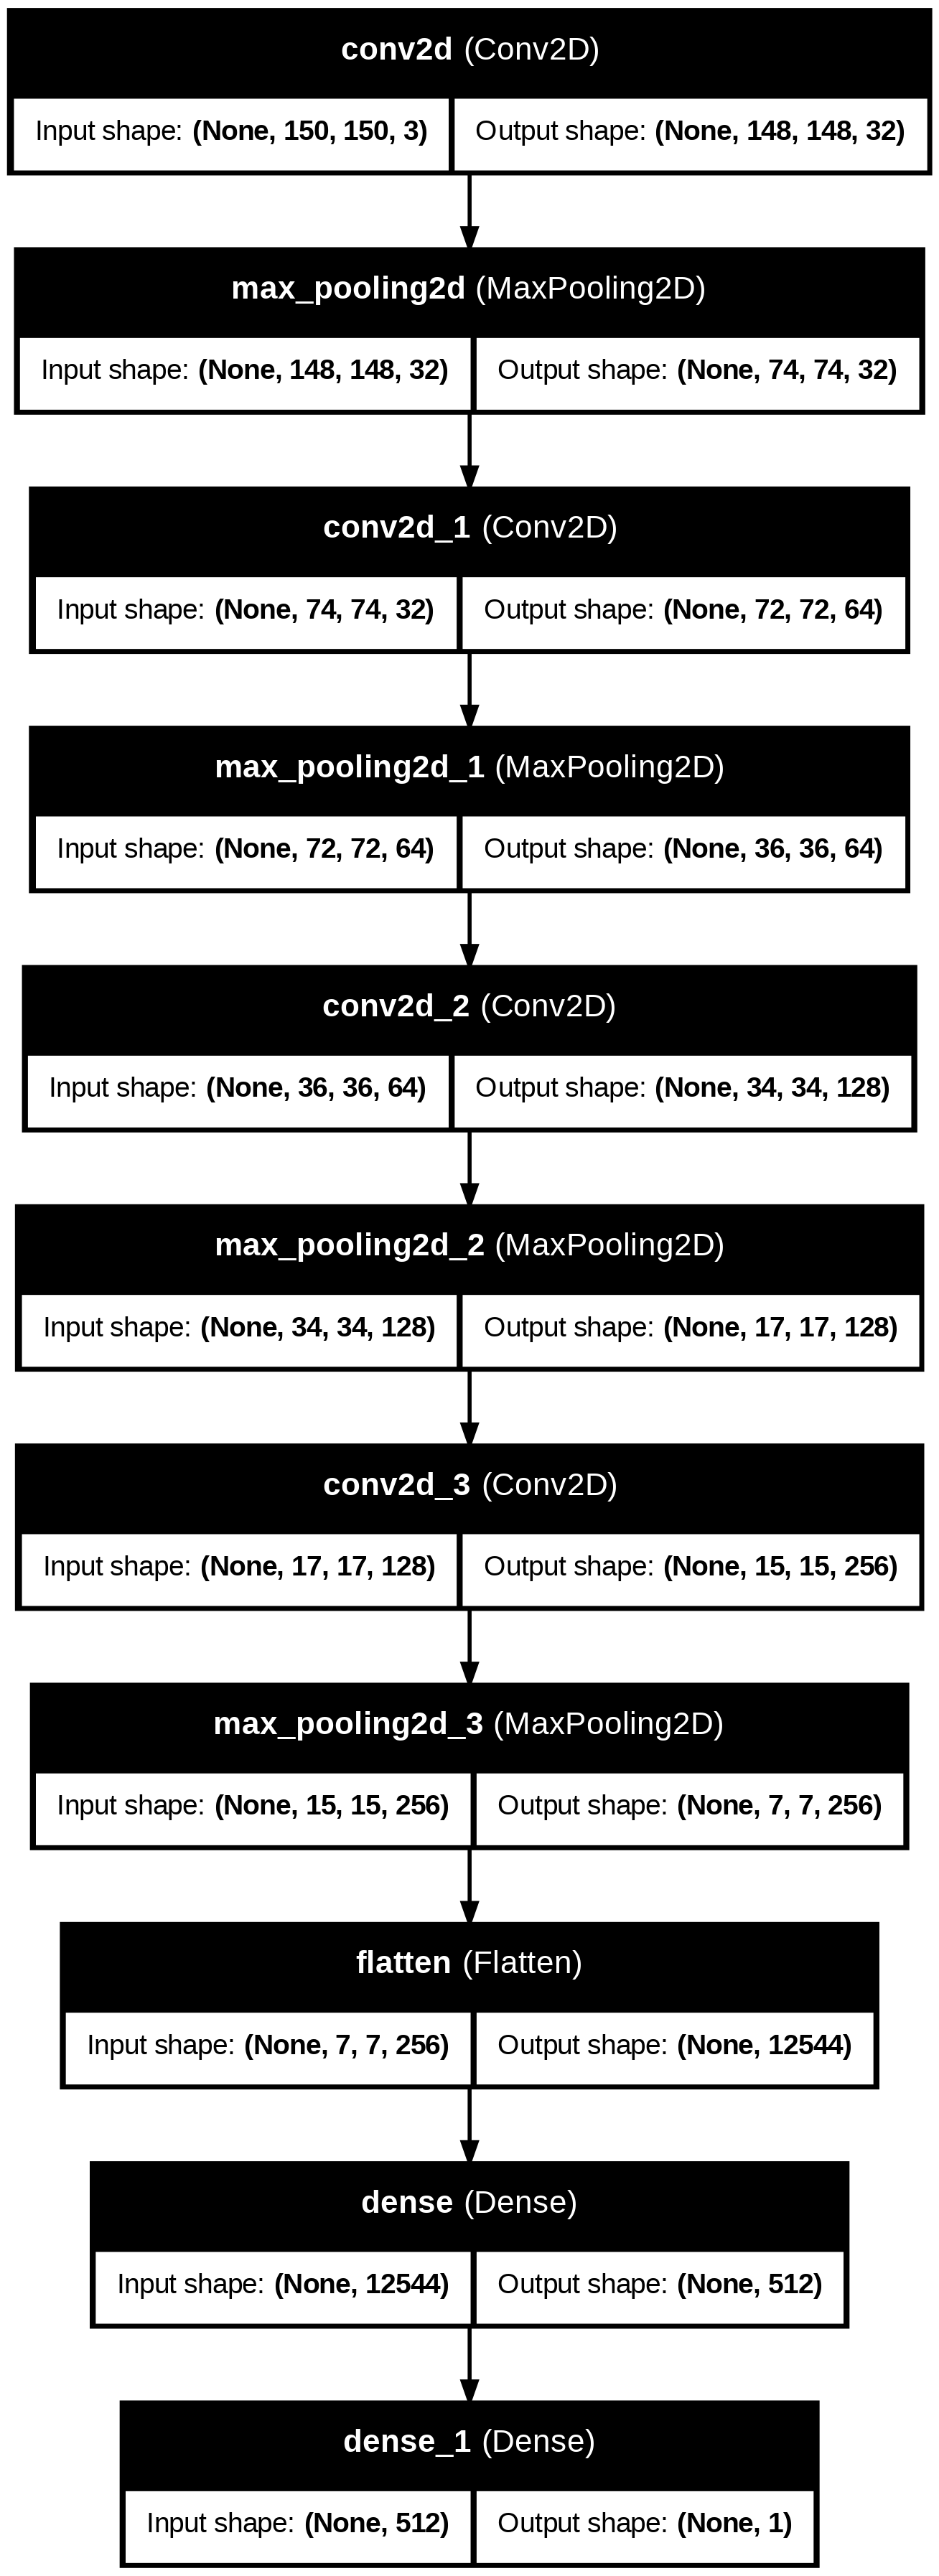

In [22]:
plot_model(model, to_file = 'Architecture.png', show_shapes=True, show_layer_names=True)

In [23]:
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [24]:
batch = 20
train_steps = np.ceil(train_generator.samples / batch)
validation_steps_per_epoch = np.ceil(validation_generator.samples / batch)
print(train_steps, validation_steps_per_epoch)

700.0 150.0


In [25]:
history = model.fit(train_generator,
                    steps_per_epoch=800,
                    epochs=10,
                    validation_data=validation_generator,
                    validation_steps=200)

Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


700/800 ━━━━━━━━━━━━━━━━━━━━ 4s 42ms/step - accuracy: 0.5796 - loss: 0.6626

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


800/800 ━━━━━━━━━━━━━━━━━━━━ 46s 50ms/step - accuracy: 0.5848 - loss: 0.6598 - val_accuracy: 0.6247 - val_loss: 0.6402
Epoch 2/10
800/800 ━━━━━━━━━━━━━━━━━━━━ 72s 43ms/step - accuracy: 0.6996 - loss: 0.5719 - val_accuracy: 0.7520 - val_loss: 0.4971
Epoch 3/10
800/800 ━━━━━━━━━━━━━━━━━━━━ 41s 43ms/step - accuracy: 0.7669 - loss: 0.4842 - val_accuracy: 0.7927 - val_loss: 0.4403
Epoch 4/10
800/800 ━━━━━━━━━━━━━━━━━━━━ 33s 41ms/step - accuracy: 0.8180 - loss: 0.4020 - val_accuracy: 0.8180 - val_loss: 0.3992
Epoch 5/10
800/800 ━━━━━━━━━━━━━━━━━━━━ 34s 42ms/step - accuracy: 0.8569 - loss: 0.3185 - val_accuracy: 0.8397 - val_loss: 0.3517
Epoch 6/10
800/800 ━━━━━━━━━━━━━━━━━━━━ 33s 42ms/step - accuracy: 0.8970 - loss: 0.2485 - val_accuracy: 0.8507 - val_loss: 0.3603
Epoch 7/10
800/800 ━━━━━━━━━━━━━━━━━━━━ 32s 40ms/step - accuracy: 0.9199 - loss: 0.1953 - val_accuracy: 0.8523 - val_loss: 0.3754
Epoch 8/10
800/800 ━━━━━━━━━━━━━━━━━━━━ 38s 48ms/step - accuracy: 0.9402 - loss: 0.1436 - val_accurac

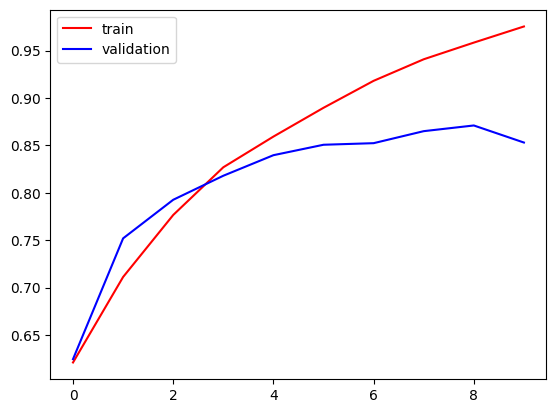

In [26]:
import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'],color='red',label='train')
plt.plot(history.history['val_accuracy'],color='blue',label='validation')
plt.legend()
plt.show()

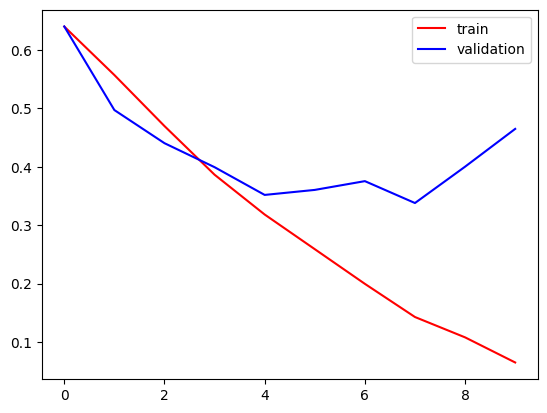

In [27]:
plt.plot(history.history['loss'],color='red',label='train')
plt.plot(history.history['val_loss'],color='blue',label='validation')
plt.legend()
plt.show()

In [28]:
final_val_acc = history.history['val_accuracy'][-1]  # Last epoch validation accuracy

print(f"Final Validation Accuracy: {final_val_acc * 100:.2f}%")

Final Validation Accuracy: 85.30%


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 797ms/step
Prediction: Dog


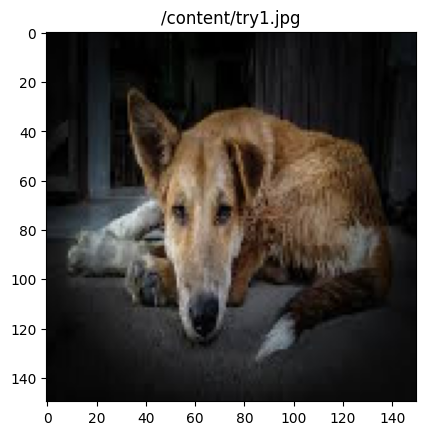

In [30]:
# prompt: predict any images

import numpy as np
from PIL import Image
import matplotlib.pyplot as plt # Import matplotlib.pyplot
from tensorflow.keras.utils import load_img, img_to_array # Import load_img and img_to_array

# Assuming 'model' is your trained model from the previous code
# and you have an image file named 'image.jpg' in the /content directory.

image_path = '/content/try1.jpg'  # Replace with the actual path to your image file


img = load_img(image_path, target_size=(150, 150)) # Use imported load_img
img_array = img_to_array(img) # Use imported img_to_array
img_array = np.expand_dims(img_array, axis=0)
img_array /= 255.

prediction = model.predict(img_array)

if prediction[0][0] > 0.5:
    print("Prediction: Dog")
else:
    print("Prediction: Cat")

# Display the image using plt.imshow
plt.imshow(img) # Use plt.imshow to display the image
plt.title(image_path)  # Add a title (optional)
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
Prediction: Dog


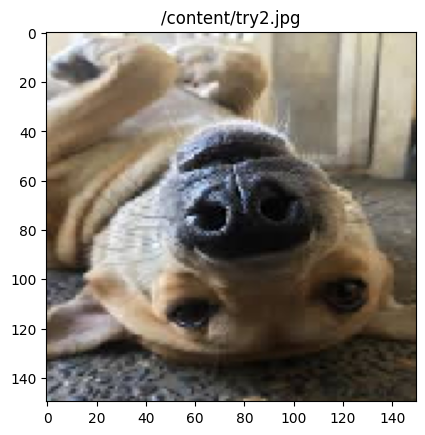

In [31]:
# prompt: predict any images

import numpy as np
from PIL import Image
import matplotlib.pyplot as plt # Import matplotlib.pyplot
from tensorflow.keras.utils import load_img, img_to_array # Import load_img and img_to_array

# Assuming 'model' is your trained model from the previous code
# and you have an image file named 'image.jpg' in the /content directory.

image_path = '/content/try2.jpg'  # Replace with the actual path to your image file


img = load_img(image_path, target_size=(150, 150)) # Use imported load_img
img_array = img_to_array(img) # Use imported img_to_array
img_array = np.expand_dims(img_array, axis=0)
img_array /= 255.

prediction = model.predict(img_array)

if prediction[0][0] > 0.5:
    print("Prediction: Dog")
else:
    print("Prediction: Cat")

# Display the image using plt.imshow
plt.imshow(img) # Use plt.imshow to display the image
plt.title(image_path)  # Add a title (optional)
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
Prediction: Cat


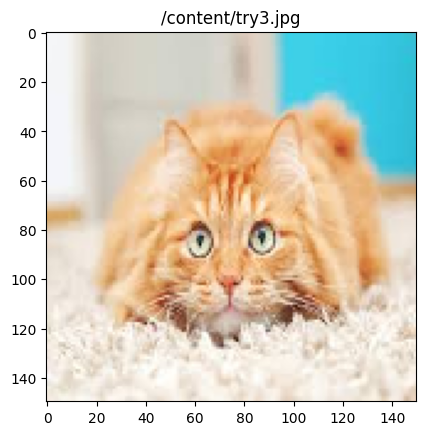

In [32]:
# prompt: predict any images

import numpy as np
from PIL import Image
import matplotlib.pyplot as plt # Import matplotlib.pyplot
from tensorflow.keras.utils import load_img, img_to_array # Import load_img and img_to_array

# Assuming 'model' is your trained model from the previous code
# and you have an image file named 'image.jpg' in the /content directory.

image_path = '/content/try3.jpg'  # Replace with the actual path to your image file


img = load_img(image_path, target_size=(150, 150)) # Use imported load_img
img_array = img_to_array(img) # Use imported img_to_array
img_array = np.expand_dims(img_array, axis=0)
img_array /= 255.

prediction = model.predict(img_array)

if prediction[0][0] > 0.5:
    print("Prediction: Dog")
else:
    print("Prediction: Cat")

# Display the image using plt.imshow
plt.imshow(img) # Use plt.imshow to display the image
plt.title(image_path)  # Add a title (optional)
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
Prediction: Cat


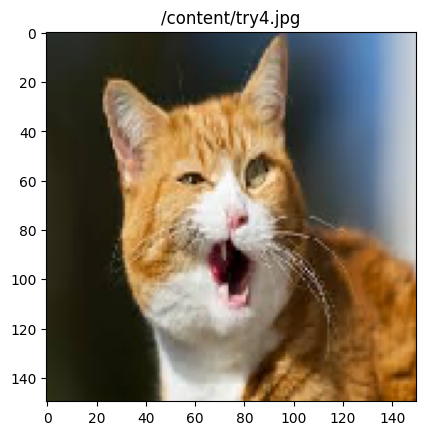

In [33]:
# prompt: predict any images

import numpy as np
from PIL import Image
import matplotlib.pyplot as plt # Import matplotlib.pyplot
from tensorflow.keras.utils import load_img, img_to_array # Import load_img and img_to_array

# Assuming 'model' is your trained model from the previous code
# and you have an image file named 'image.jpg' in the /content directory.

image_path = '/content/try4.jpg'  # Replace with the actual path to your image file


img = load_img(image_path, target_size=(150, 150)) # Use imported load_img
img_array = img_to_array(img) # Use imported img_to_array
img_array = np.expand_dims(img_array, axis=0)
img_array /= 255.

prediction = model.predict(img_array)

if prediction[0][0] > 0.5:
    print("Prediction: Dog")
else:
    print("Prediction: Cat")

# Display the image using plt.imshow
plt.imshow(img) # Use plt.imshow to display the image
plt.title(image_path)  # Add a title (optional)
plt.show()

In [34]:
# prompt: make a function where i give image path and it will predict whether it is cat or dog and show me image

def predict_image(image_path):
    """Predicts whether an image is a cat or a dog and displays the image.

    Args:
        image_path: The path to the image file.
    """
    try:
        img = load_img(image_path, target_size=(150, 150))
        img_array = img_to_array(img)
        img_array = np.expand_dims(img_array, axis=0)
        img_array /= 255.

        prediction = model.predict(img_array)

        if prediction[0][0] > 0.5:
            predicted_class = "Dog"
        else:
            predicted_class = "Cat"

        plt.imshow(img)
        plt.title(f"Prediction: {predicted_class} ({image_path})")
        plt.show()

    except FileNotFoundError:
        print(f"Error: Image file not found at {image_path}")
    except Exception as e:
        print(f"An error occurred: {e}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 253ms/step


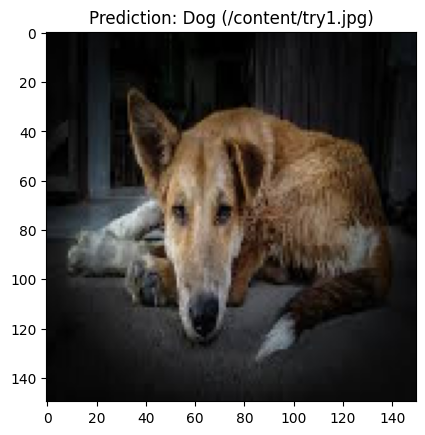

In [36]:
predict_image('/content/try1.jpg')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


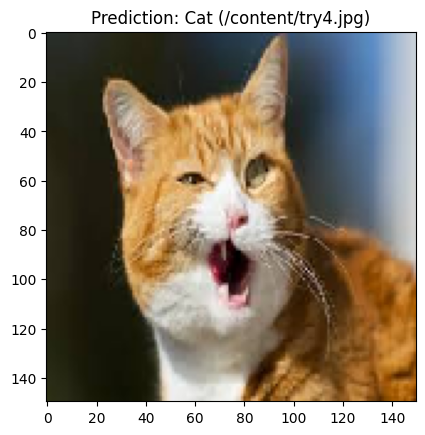

In [37]:
predict_image('/content/try4.jpg')